Before starting, you will need to install some packages to reproduce the baseline.

In [1]:
!pip install tqdm
!pip install scikit-learn

In [2]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Data architecture


```
your_data_dir/
├── train_output.csv
├── train_input/
│   ├── images/
│       ├── ID_001/
│           ├── ID_001_tile_000_17_170_43.jpg
...
│   └── moco_features/
│       ├── ID_001.npy
...
├── test_input/
│   ├── images/
│       ├── ID_003/
│           ├── ID_003_tile_000_16_114_93.jpg
...
│   └── moco_features/
│       ├── ID_003.npy
...
├── supplementary_data/
│   ├── baseline.ipynb
│   ├── test_metadata.csv
│   └── train_metadata.csv
```

For instance, `your_data_dir = /storage/DATA_CHALLENGE_ENS_2022/`


## Data loading

In [3]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("/Users/enfants/Code/Detecting PIK3CA mutation in breast cancer")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$.

In [7]:
X_train = []
y_train = []
centers_train = []
patients_train = []
samples_train = []

for sample, label, center, patient in tqdm(  # loading bar
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # split coords / features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks

    # append each tile as a training sample
    X_train.append(features)
    y_train.append(np.full(len(features), label))
    centers_train.append(np.full(len(features), center))
    patients_train.append(np.full(len(features), patient))
    samples_train.append(np.full(len(features), sample))

# convert to numpy arrays
X_train = np.vstack(X_train)          # (N_tiles, 2048)
y_train = np.concatenate(y_train)     # (N_tiles,)
centers_train = np.concatenate(centers_train)
patients_train = np.concatenate(patients_train)
samples_train = np.concatenate(samples_train)

print(X_train.shape, y_train.shape)

100%|██████████| 344/344 [00:01<00:00, 297.56it/s]


(344000, 2048) (344000,)


## 5-fold cross validation

In [11]:
# /!\ patient-level split: all tiles from a patient stay in the same split

patients_unique = np.unique(patients_train)

y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344000 unique samples
305 unique patients
3 unique centers


In [ ]:
aucs = []
lrs = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        lr = LogisticRegression(C=0.01, solver="liblinear")
        # fit it
        lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = lr.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        lrs.append(lr)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)

AUC on split 0 fold 0: 0.543
AUC on split 0 fold 1: 0.570
AUC on split 0 fold 2: 0.602
AUC on split 0 fold 3: 0.622
AUC on split 0 fold 4: 0.554
----------------------------
AUC on split 1 fold 0: 0.586
AUC on split 1 fold 1: 0.611
AUC on split 1 fold 2: 0.578
AUC on split 1 fold 3: 0.554
AUC on split 1 fold 4: 0.532
----------------------------
AUC on split 2 fold 0: 0.553
AUC on split 2 fold 1: 0.581
AUC on split 2 fold 2: 0.555


# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [7]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))

X_test = np.array(X_test)

100%|██████████| 149/149 [00:00<00:00, 319.24it/s]


## Inference

In [8]:
preds_test = 0
# loop over the classifiers
for lr in lrs:
    preds_test += lr.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(lrs)

## Saving predictions

In [9]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.423755
1,ID_004.npy,0.418803
2,ID_008.npy,0.414833
3,ID_009.npy,0.417029
4,ID_010.npy,0.384043


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [10]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 344000
Test: 149000
Total: 493000



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [11]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

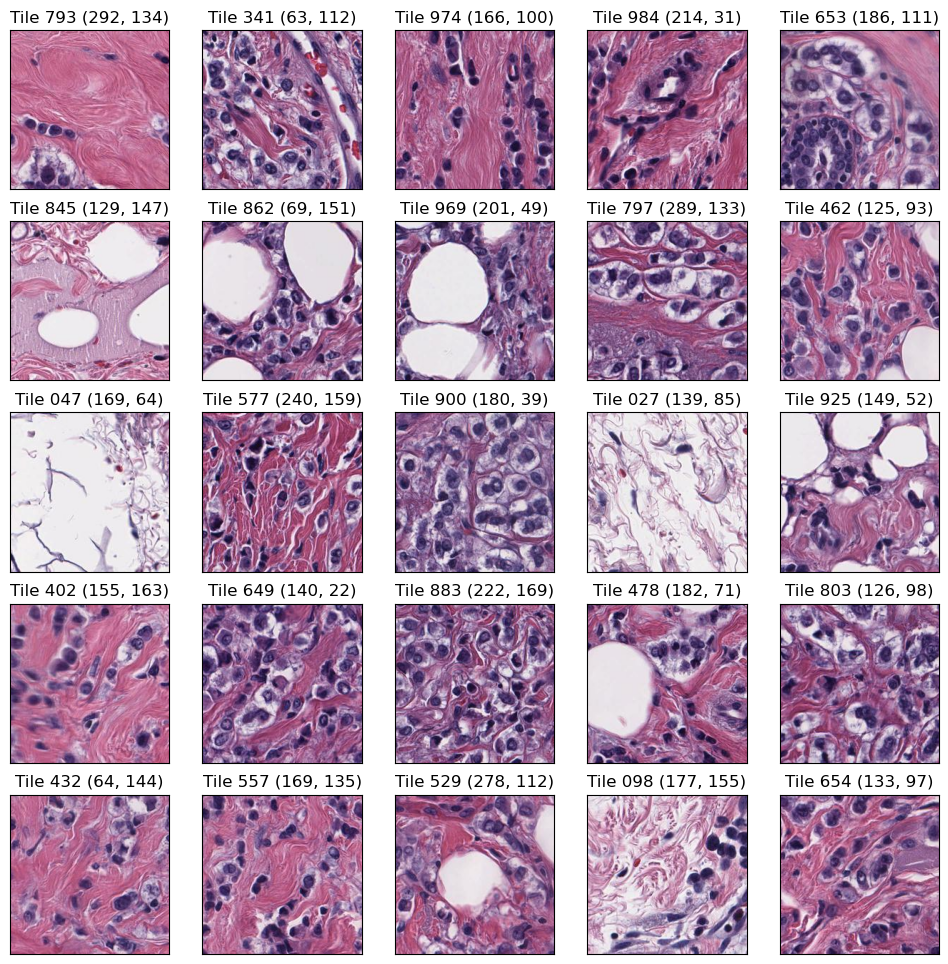

In [12]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [13]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [14]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



['ID_001_tile_793_17_292_134.jpg',
 'ID_001_tile_341_17_63_112.jpg',
 'ID_001_tile_974_17_166_100.jpg',
 'ID_001_tile_984_17_214_31.jpg',
 'ID_001_tile_653_17_186_111.jpg',
 'ID_001_tile_845_17_129_147.jpg',
 'ID_001_tile_862_17_69_151.jpg',
 'ID_001_tile_969_17_201_49.jpg',
 'ID_001_tile_797_17_289_133.jpg',
 'ID_001_tile_462_17_125_93.jpg']